# Solve the $\omega$ equation by [Green's function](https://en.wikipedia.org/wiki/Green's_function) methods
### in a small patch of atmosphere, treated as a Cartesian xyz block. The inverse Laplacian for each gridpoint of forcing decays as 1/distance (D. Nolan 2023, *pers. comm.*); how do the units and thus absolute values work? Need to follow up. 

<a id="top"></a>

### Wikipedia's version of the omega equation
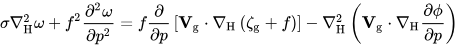 

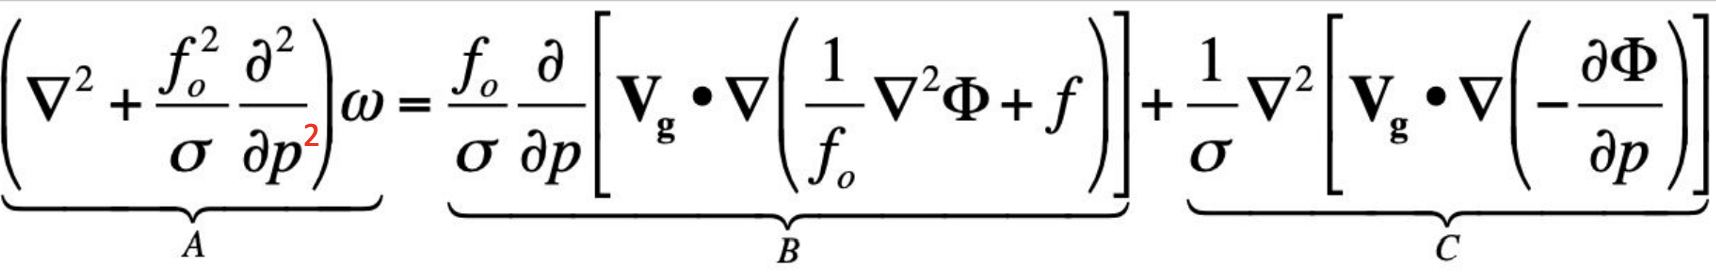
with $\sigma$ = static stability parameter from dT/dt term  ω$\sigma$

## The Idea: 

Invert the operator on the LHS to obtain $\omega$, treating the RHS terms as a 3D array of "forcing" in some finite patch of the atmosphere. For simplicity we will treat f and $\sigma$ as constants, with a little nod of appreciation of how the stability factor $\sigma$ rescales vertical relative to horizontal components of 3D distance. 

Those forcing terms are easily computed ([bottom of notebook](#forcing_calc)), they just involve differentiation and multiplication of data arrays.  

### To do the inversion of the 3D array of forcing, there are 5 steps: 

1. Enforce $\omega$ = 0 at the surface using an ["image" or mirrored copy](https://en.wikipedia.org/wiki/Method_of_images) of the forcing, in a fictitious flipped copy of the atmosphere below the surface. This doubles the forcing array size in the vertical. Periodic rolling of the array is tantamount to another 0 boundary condition at the top of the atmospheric data block (tropopause or perhaps far above although constant static stability becomes a poor approximation in the upper atmosphere). 
2. Pad the mirrored forcing data array with zeros horizontally. This increases the now-doubled initial array size by (3x3) = 9 times. So it's a 9x bigger array than the original forcing.
3. For each gridpoint in the forcing, the induced $\omega$ is proportional to 1/distance (1/r), rescaling distance in pressure coordinates according to $r = [\Delta x^2 + \Delta y^2 + \Delta z*^2]^{1/2} = [\Delta x^2 + \Delta y^2 + (\sigma/f_o^2)\Delta p^2]^{1/2}$. If the data are interpolated onto a uniform z* vertical coordinate, we loop over all the forcing points by rolling the array systematically, and sum up all these induced contributions dividing by an also-rolled array of r we only have to calculate once.
4. In the results array, shave off all the padded and mirrored regions to recover the result.
5. Interpolate the result's vertical coordinate back to the original pressure levs, to regain the array size and shape of the forcing. 

In [1]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt

# Interpolate forcing onto a rescaled pseudo-vertical coordinate z*
### for purposes of 1/distance weighting in the Greens function sum
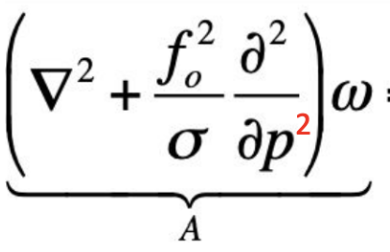

### dz* = $(\sigma / f_o^2)^{1/2} dp$ 
#### Let's take sigma as a constant for now, $\sigma = (T/\theta) d\theta/dp \simeq \Delta \theta / \Delta p$, so a uniform-z* grid is just a uniform pressure grid. 

$\sigma = (T/\theta) d \theta / dp$ so we can understand that $\sigma dp^2 = (T/\theta) d \theta / dp (dp dp) = (T/\theta) d \theta dp$, or in words the vertical distance coordinate over which the signal decays as 1/distance is partly a "theta distance", and partly a p distance weighted by the p-dependent factor $T/\theta$.  In other words, more-stable layers attenuate the vertical influence of the forcing terms somewhat, and perhaps an instratified layer shields the effects entirely, but that case probably violates assumptions of the whole derivation so don't take it too literally. 

In [74]:
FDS = xr.open_dataset('./QGOE_forcing_WHch8case_M2coarsened_trunc85.nc') # calculated at bottom of notebook, saved in local file

In [75]:
Theta_thickness = 30 # Kelvin, tropopause depth, down-weighted for the T/theta term
sigma = Theta_thickness / (90000.) # K/Pa
f0 = 1e-4 # inverse seconds
dp = FDS.lev.diff('lev')*100. # Pa
dzstar = dp* np.sqrt(sigma)/f0

zstar = np.flip(dzstar).cumsum().rename('zstar') # result is on 'lev' coordinate 
FDS['zstar'] = zstar
FDS = FDS.fillna( FDS.zstar[1]+dzstar[0] ) # fill the nan of zstar at 100mb 
# zstar.plot(size=2)

In [76]:
original_plevs = FDS['lev'] ## for later, for interpolating back to original levs 

In [77]:
# Interpolate forcing and zstar values onto 21 uniform pressure levs... 

uniformp = np.linspace(100, 1000, 21)
FDSi = FDS.interp(lev=uniformp, method='linear')
FDSi

<xarray.Dataset>
Dimensions:  (lev: 21, lat: 41, lon: 49)
Coordinates:
  * lat      (lat) float64 54.75 53.75 52.75 51.75 ... 17.75 16.75 15.75 14.75
  * lon      (lon) float64 -124.7 -123.4 -122.2 -120.9 ... -67.19 -65.94 -64.69
    time     datetime64[ns] 1998-11-10T09:00:00
  * lev      (lev) float64 100.0 145.0 190.0 235.0 ... 865.0 910.0 955.0 1e+03
Data variables:
    DVA      (lev, lat, lon) float64 -1.592e-14 -2.218e-14 ... -4.261e-14
    LapTA    (lev, lat, lon) float64 -7.243e-14 -7.44e-14 ... -8.853e-14
    Phi      (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    omega    (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    dPhidp   (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    zstar    (lev) float64 -9.129e+05 -1.734e+06 ... -1.607e+07 -1.689e+07

### Testing the rolling and summing algorithm visually 

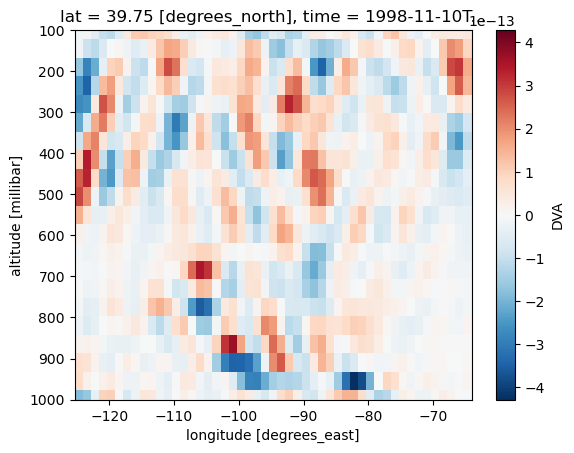

In [78]:
FDSi.DVA.sel(lat=40, method='nearest').plot(ylim=[1000,100])

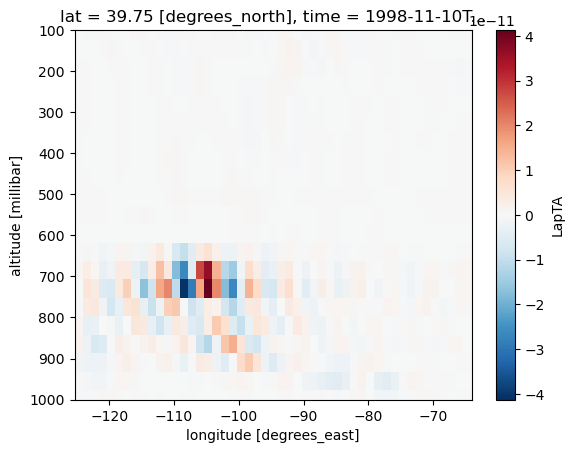

In [79]:
FDSi.LapTA.sel(lat=40, method='nearest').plot(ylim=[1000,100])

# Set the forcing F for the inversion process

In [80]:
F = FDSi.DVA.values + FDSi.LapTA.values  # Numpy array shape (p, lat, lon)

NP = F.shape[0]
NLAT = F.shape[1]
NLON = F.shape[2]

#plt.pcolormesh(F[:,10,:]); plt.colorbar()
#plt.title('debug F shape '+str(F.shape))
# Keep only the upper-west forcing for debugging tests: passed! 
# F[:,:,10:] = 0 
# F[10:,:,:] = 0 

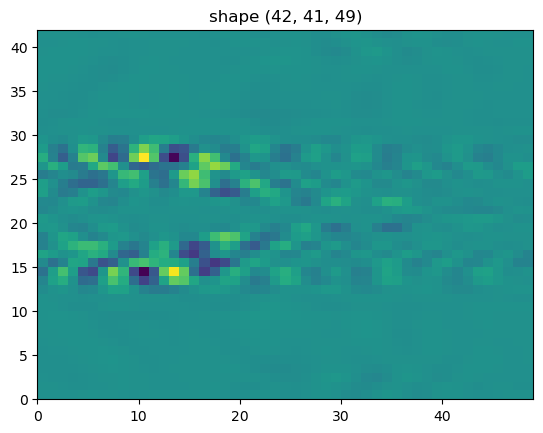

In [81]:
# Mirroring with flipped sign: omega=0 BC at 1000 mb (bottom of data)

mirF = np.concatenate((F, -F[::-1]), axis=0) 
plt.pcolormesh(mirF[:,10,:])
plt.title('shape ' + str(np.shape(mirF))); 

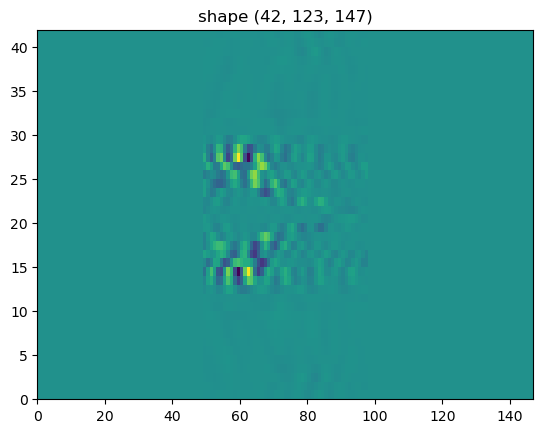

In [82]:
# Padding horizontally to ignore all forcing outside data box 
# No need for vertical padding (mirror BC across data top)

padding_size = ((0, 0), (NLAT, NLAT), (NLON, NLON))

# Pad the array with zeros
padF = np.pad(mirF, padding_size, mode='constant', constant_values=0)
plt.pcolormesh(padF[:,10+NLAT,:])
plt.title('shape '+str( padF.shape )); 

# Compute distance array to divide by
### Compute it for one point in the center

1/distance is measured with the zstar as derived in comments above. 

In [83]:
# Coordinate scalings for 1/r distance calculation, Cartesian tangent verion 
dy = float(FDS.lat.diff('lat').mean().values)  * 111111.1 # meters
dx = float(FDS.lon.diff('lon').mean().values * 111111.1 *\
            np.cos(FDS.lat *np.pi/180.).mean() ) # meters
dzstar = float(FDSi.zstar.diff('lev').mean().values) # pseudo meters? 

dx, dy, dzstar  ## Meters, and pseudo-meters in zstar

(111699.77034977844, -111111.1, -798762.0630283668)

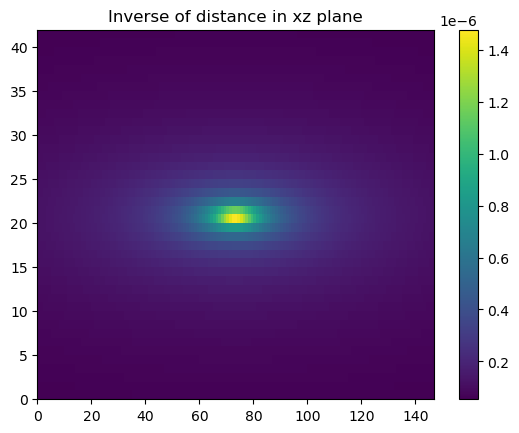

In [84]:
# Numpy array shape NP,NLAT,NLON (p, lat, lon)

# Get the center coordinates
shape = padF.shape
center = np.array([(dim - 1) / 2 for dim in shape])
# Create a grid of indices
indices = np.indices(shape)

# Calculate the 3 coordinate distances from the central point, avoiding zeros for 1/distance 
coord_distances = (indices - center[:, None, None, None] + 0.23)
coord_distances[0,:,:,:] *= dzstar
coord_distances[1,:,:,:] *= dy
coord_distances[2,:,:,:] *= dx

# sum the square over the 3 dimensions 
dist = np.sqrt(np.sum( coord_distances**2, axis=0))
invdist = 1.0/dist
plt.pcolormesh(invdist[:,14+NLAT,:]); plt.colorbar()
plt.title('Inverse of distance in xz plane');

In [85]:
invdist.shape

(42, 123, 147)

In [103]:
# THE BIG LOOP 

# 3D smoothing by Laplacian inversion. Sum of rolled offsets of padF/distance.
# Both arrays are rolled, to center each point of the forcing and broadcast its influence 
# to the entire results array. 
# Rolls are negative to put the unpadded part of result into the easiest corner 

# Numpy array shape (p, lat, lon)
# Number of rolls in each direction
rolls_x, rolls_y = NLON, NLAT

result = padF*0 # correct shaped array 

# Roll the inverse distance array over the whole data-containing parf of padF. 
# scale that array by the forcing at its zero point, and accumulate a sum . 
# First loop accesses the original data, then other rolls work on the rolled array

for i in range(-NLON//2, NLON//2):
    print('lon ',i) 
    for j in range(-NLAT//2, NLAT//2):
        for k in range(-NP, NP):
            
            # invdist spatial pattern, weighted by forcing strength
            rollinvdist = np.roll(invdist, [k,j,i], axis=(0, 1, 2))

            # Middle of the paddded array is NP, but NLAT + NLAT//2 etc. 
            Fvalue = padF[NP +k, NLAT+NLAT//2 +j, NLON+NLON//2 +i] 

            result += Fvalue * rollinvdist *dx*dy*dzstar

lon  -25
lon  -24
lon  -23
lon  -22
lon  -21
lon  -20
lon  -19
lon  -18
lon  -17
lon  -16
lon  -15
lon  -14
lon  -13
lon  -12
lon  -11
lon  -10
lon  -9
lon  -8
lon  -7
lon  -6
lon  -5
lon  -4
lon  -3
lon  -2
lon  -1
lon  0
lon  1
lon  2
lon  3
lon  4
lon  5
lon  6
lon  7
lon  8
lon  9
lon  10
lon  11
lon  12
lon  13
lon  14
lon  15
lon  16
lon  17
lon  18
lon  19
lon  20
lon  21
lon  22
lon  23


In [87]:
#i,j,k = 0,0,0  #DEBUGGING TESTS 

#rollinvdist = np.roll(invdist, [k,j,i], axis=(0, 1, 2))
#Fvalue = padF[NP//2+k, NLAT+NLAT//2+j, NLON+NLON//2+i] 
#test = Fvalue * rollinvdist 
#plt.pcolormesh(test[:,40,:]); plt.colorbar()

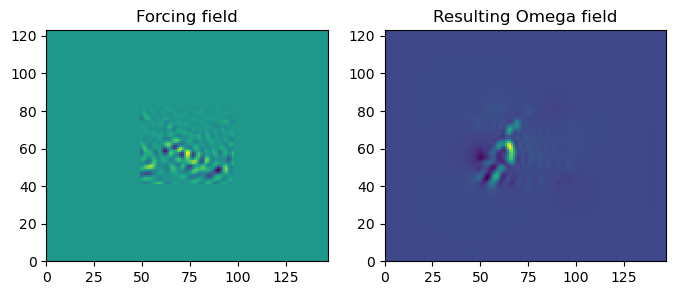

In [88]:
# Plot Result in middle troposphere: horizontal structure looks right 
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].pcolormesh(padF[5,:,:]); axs[0].set_title('Forcing field')
axs[1].pcolormesh(result[15,:,:])
plt.title('Resulting Omega field');

/var/folders/8f/r03vpksx46l5r53nhvpfywtc0000gn/T/ipykernel_74561/3237393323.py:8: UserWarning: The following kwargs were not used by contour: 'levs'
  plt.contour   (results_core[:,10,:], colors='red', levs=20)


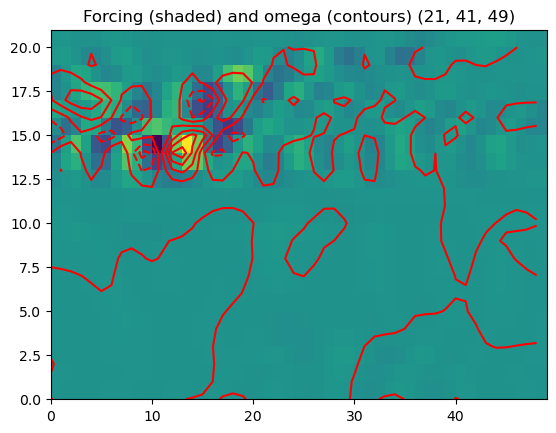

In [105]:
# Extract the middle 1/3 along each dimension, the half with troposphere array in right order (100 to 1000)
# Results show it should be rolled by 1 lev 

forcing_core = padF  [:NP, NLAT:2*NLAT, NLON:2*NLON]
results_core = np.roll(result, 1, axis=0)[:NP, NLAT:2*NLAT, NLON:2*NLON]

plt.pcolormesh(forcing_core[:,10,:])
plt.contour   (results_core[:,10,:], colors='red', levs=20)

plt.title('Forcing (shaded) and omega (contours) '+str( results_core.shape )); 

In [106]:
# Create a new DataArray with the same coordinates as the existing DataArrays. 
# Negative sign is empiricism about final sign 

res_da = xr.DataArray(-results_core,
                    dims=['lev','lat', 'lon'],
                    coords={'lev':FDSi.lev, 'lat': FDSi.lat, 'lon': FDSi.lon})
FDSi.update({'QGomega': res_da})

<xarray.Dataset>
Dimensions:        (lev: 21, lat: 41, lon: 49)
Coordinates:
  * lat            (lat) float64 54.75 53.75 52.75 51.75 ... 16.75 15.75 14.75
  * lon            (lon) float64 -124.7 -123.4 -122.2 ... -67.19 -65.94 -64.69
    time           datetime64[ns] 1998-11-10T09:00:00
  * lev            (lev) float64 100.0 145.0 190.0 235.0 ... 910.0 955.0 1e+03
Data variables:
    DVA            (lev, lat, lon) float64 -1.592e-14 -2.218e-14 ... -4.261e-14
    LapTA          (lev, lat, lon) float64 -7.243e-14 -7.44e-14 ... -8.853e-14
    Phi            (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    omega          (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    dPhidp         (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    zstar          (lev) float64 -9.129e+05 -1.734e+06 ... -1.607e+07 -1.689e+07
    QGomega        (lev, lat, lon) float64 0.006964 0.007416 ... 0.01015
    QGomega_DVA    (lev, lat, lon) float64 -2.345e-19 -1.697e-19 ... -3.407e-18
    QGomega_LapTA  (lev, lat, lon) float64 7.025e-19 7.481e-19 ... 1.024e-18

# Do the forcing terms individually 

In [107]:
# THE BIG LOOP as a function

def invertlap(): 
    rolls_x, rolls_y = NLON, NLAT
    result = padF*0 # correct shaped array 

# Roll the inverse distance array over the whole data-containing parf of padF. 
# scale that array by the forcing at its zero point, and accumulate a sum . 
# First loop accesses the original data, then other rolls work on the rolled array

    for i in range(-NLON//2, NLON//2):
        print('lon ',i) 
        for j in range(-NLAT//2, NLAT//2):
            for k in range(-NP, NP):
                
            # invdist spatial pattern, weighted by forcing strength
                rollinvdist = np.roll(invdist, [k,j,i], axis=(0, 1, 2))

            # Middle of the paddded array is NP, but NLAT + NLAT//2 etc. 
                Fvalue = padF[NP +k, NLAT+NLAT//2 +j, NLON+NLON//2 +i] 

                result += Fvalue * rollinvdist *dx*dy*dzstar
    return result 

In [119]:
# FASTER! Vectorize

def invertlap_vec(): 
    result = padF*0 # correct shaped array 

# Roll the inverse distance array over the whole data-containing parf of padF. 
# scale that array by the forcing at its zero point, and accumulate a sum . 
    i_vals = np.arange(-NLON//2, NLON//2)
    j_vals = np.arange(-NLAT//2, NLAT//2)
    k_vals = np.arange(-NP, NP)

# Create grids of indices
    i_grid, j_grid, k_grid = np.meshgrid(i_vals, j_vals, k_vals, indexing='ij')

# Use broadcasting and np.roll to perform the operation without explicit loops
    rolled = np.roll(invdist, [k_grid, j_grid, i_grid], axis=(0, 1, 2))
    F_values = F[k_grid, j_grid, i_grid]

    result = np.sum(F_values * rolled, axis=(0, 1, 2))
    
    return result

In [120]:
F = FDSi.DVA.values # + FDSi.LapTA.values  # Numpy array shape (p, lat, lon)
mirF = np.concatenate((F, -F[::-1]), axis=0) 
padF = np.pad(mirF, padding_size, mode='constant', constant_values=0)

resultDVA_vec = invertlap_vec()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3, 49, 41, 42) and arg 1 with shape (3,).

In [138]:
#rolled = np.roll(invdist, [k_grid, j_grid, i_grid], axis=(0, 1, 2))
#rolled = np.roll(invdist, shift=[k_grid, j_grid, i_grid], axis=(0, 1, 2))
#rolled = np.roll(invdist, shift=(k_grid, j_grid, i_grid), axis=(2, 1, 0))

invdist.shape

(42, 123, 147)

In [135]:
k_grid.shape, i_grid.shape, j_grid.shape

((49, 41, 42), (49, 41, 42), (49, 41, 42))

In [123]:
    i_vals = np.arange(-NLON//2, NLON//2)
    j_vals = np.arange(-NLAT//2, NLAT//2)
    k_vals = np.arange(-NP, NP)

# Create grids of indices
    i_grid, j_grid, k_grid = np.meshgrid(i_vals, j_vals, k_vals, indexing='ij')


In [125]:
k_grid.shape

(49, 41, 42)

In [127]:
[k_grid, j_grid, i_grid]

AttributeError: 'list' object has no attribute 'shape'

In [108]:
# The two forcing terms individually: DVA and LapTA

F = FDSi.DVA.values # + FDSi.LapTA.values  # Numpy array shape (p, lat, lon)
mirF = np.concatenate((F, -F[::-1]), axis=0) 
padF = np.pad(mirF, padding_size, mode='constant', constant_values=0)

resultDVA = invertlap()
resDVA = np.roll(resultDVA, 1, axis=0) [:NP, NLAT:2*NLAT, NLON:2*NLON]
resDVA_da = xr.DataArray(-resDVA,
                    dims=['lev','lat', 'lon'],
                    coords={'lev':FDSi.lev, 'lat': FDSi.lat, 'lon': FDSi.lon})


F = FDSi.LapTA.values  # Numpy array shape (p, lat, lon)
mirF = np.concatenate((F, -F[::-1]), axis=0) 
padF = np.pad(mirF, padding_size, mode='constant', constant_values=0)

resultLapTA = invertlap()
resLapTA = np.roll(resultLapTA, 1, axis=0) [:NP, NLAT:2*NLAT, NLON:2*NLON]
resLapTA_da = xr.DataArray(-resLapTA,
                    dims=['lev','lat', 'lon'],
                    coords={'lev':FDSi.lev, 'lat': FDSi.lat, 'lon': FDSi.lon})


FDSi.update({'QGomega_DVA': resDVA_da})
FDSi.update({'QGomega_LapTA': resLapTA_da})

lon  -25
lon  -24
lon  -23
lon  -22
lon  -21
lon  -20
lon  -19
lon  -18
lon  -17
lon  -16
lon  -15
lon  -14
lon  -13
lon  -12
lon  -11
lon  -10
lon  -9
lon  -8
lon  -7
lon  -6
lon  -5
lon  -4
lon  -3
lon  -2
lon  -1
lon  0
lon  1
lon  2
lon  3
lon  4
lon  5
lon  6
lon  7
lon  8
lon  9
lon  10
lon  11
lon  12
lon  13
lon  14
lon  15
lon  16
lon  17
lon  18
lon  19
lon  20
lon  21
lon  22
lon  23
lon  -25
lon  -24
lon  -23
lon  -22
lon  -21
lon  -20
lon  -19
lon  -18
lon  -17
lon  -16
lon  -15
lon  -14
lon  -13
lon  -12
lon  -11
lon  -10
lon  -9
lon  -8
lon  -7
lon  -6
lon  -5
lon  -4
lon  -3
lon  -2
lon  -1
lon  0
lon  1
lon  2
lon  3
lon  4
lon  5
lon  6
lon  7
lon  8
lon  9
lon  10
lon  11
lon  12
lon  13
lon  14
lon  15
lon  16
lon  17
lon  18
lon  19
lon  20
lon  21
lon  22
lon  23


<xarray.Dataset>
Dimensions:        (lev: 21, lat: 41, lon: 49)
Coordinates:
  * lat            (lat) float64 54.75 53.75 52.75 51.75 ... 16.75 15.75 14.75
  * lon            (lon) float64 -124.7 -123.4 -122.2 ... -67.19 -65.94 -64.69
    time           datetime64[ns] 1998-11-10T09:00:00
  * lev            (lev) float64 100.0 145.0 190.0 235.0 ... 910.0 955.0 1e+03
Data variables:
    DVA            (lev, lat, lon) float64 -1.592e-14 -2.218e-14 ... -4.261e-14
    LapTA          (lev, lat, lon) float64 -7.243e-14 -7.44e-14 ... -8.853e-14
    Phi            (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    omega          (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    dPhidp         (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    zstar          (lev) float64 -9.129e+05 -1.734e+06 ... -1.607e+07 -1.689e+07
    QGomega        (lev, lat, lon) float64 0.006964 0.007416 ... 0.01015
    QGomega_DVA    (lev, lat, lon) float64 -0.002325 -0.001682 ... -0.03378
    QGomega_LapTA  (lev, lat, lon) float64 0.006964 0.007416 ... 0.01015

In [109]:
dx*dy*dzstar/1e14

99.13503342469993

# Interpolate back to original p levs, in case that matters 
Someday might use weirder zstar perhaps 

In [110]:
# Interpolate back onto original pressure levs... 
Res_ds = FDSi.interp(lev=original_plevs, method='linear')
Res_ds

<xarray.Dataset>
Dimensions:        (lev: 25, lat: 41, lon: 49)
Coordinates:
  * lat            (lat) float64 54.75 53.75 52.75 51.75 ... 16.75 15.75 14.75
  * lon            (lon) float64 -124.7 -123.4 -122.2 ... -67.19 -65.94 -64.69
    time           datetime64[ns] 1998-11-10T09:00:00
  * lev            (lev) float64 1e+03 975.0 950.0 925.0 ... 200.0 150.0 100.0
Data variables:
    DVA            (lev, lat, lon) float64 -1.591e-14 -4.606e-14 ... -2.677e-15
    LapTA          (lev, lat, lon) float64 -2.679e-13 -1.938e-13 ... -1.201e-14
    Phi            (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    omega          (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    dPhidp         (lev, lat, lon) float64 -1.689e+07 -1.689e+07 ... -1.689e+07
    zstar          (lev) float64 -1.689e+07 -1.643e+07 ... -1.826e+06 -9.129e+05
    QGomega        (lev, lat, lon) float64 0.02514 0.01514 ... -0.0006481
    QGomega_DVA    (lev, lat, lon) float64 0.006554 0.01019 ... -0.001244
    QGomega_LapTA  (lev, lat, lon) float64 0.02514 0.01514 ... -0.0006481

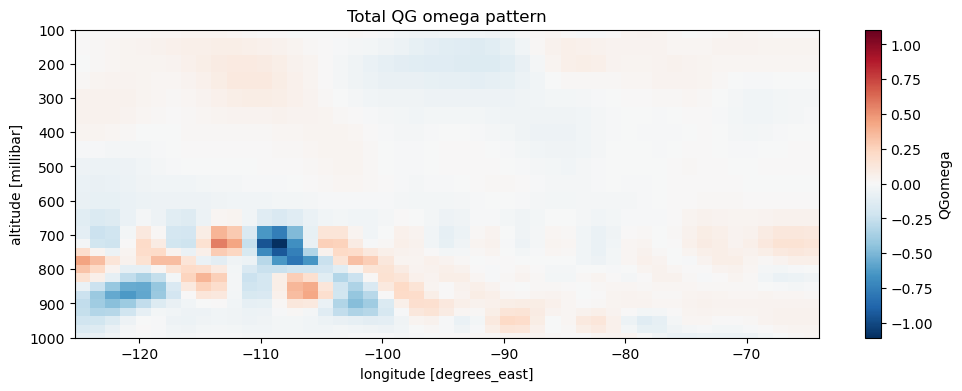

In [111]:
# Look at a cross section of the result at 45N 

Res_ds.QGomega.sel(lat=45, method='nearest').plot( ylim=[1000,100], size=4, aspect=3)
plt.title('Total QG omega pattern');

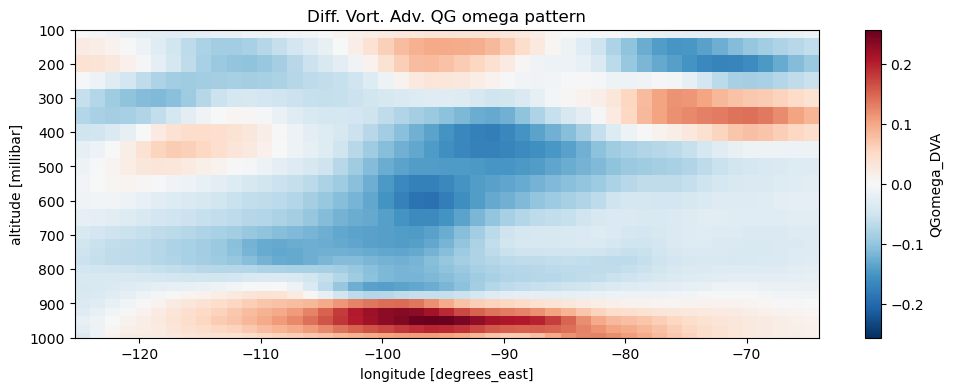

In [112]:
# Influence of TERM B (Diff. Vort. Adv.) cross section at 45N 

Res_ds.QGomega_DVA.sel(lat=45, method='nearest').plot( ylim=[1000,100], size=4, aspect=3)
plt.title('Diff. Vort. Adv. QG omega pattern');

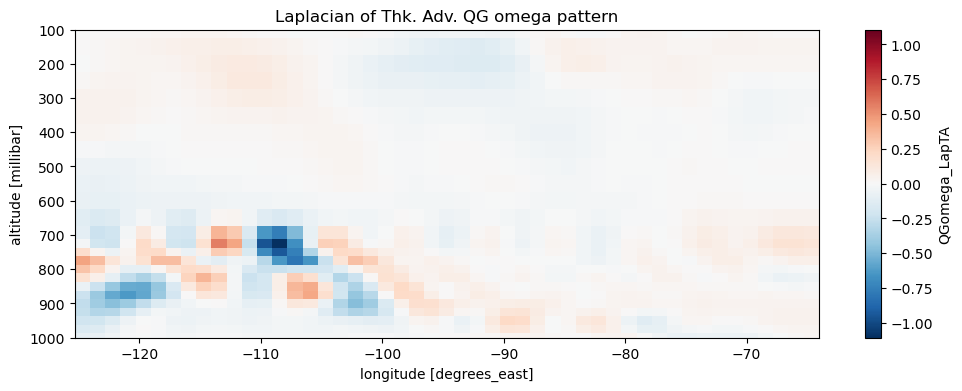

In [113]:
# Influence of TERM C (Thermal Advection) cross section at 45N 

Res_ds.QGomega_LapTA.sel(lat=45, method='nearest').plot( ylim=[1000,100], size=4, aspect=3)
plt.title('Laplacian of Thk. Adv. QG omega pattern');

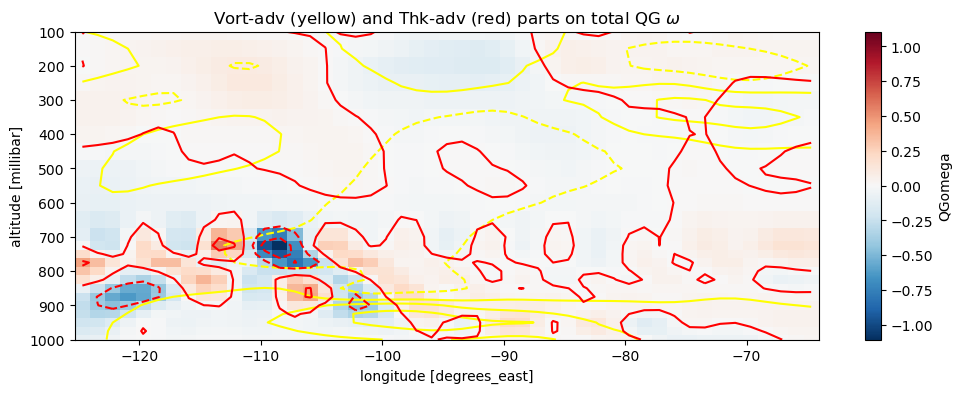

In [114]:
Res_ds.QGomega.sel(lat=45, method='nearest').plot( ylim=[1000,100], size=4, aspect=3)
Res_ds.QGomega_DVA.sel(lat=45, method='nearest').plot.contour(colors='yellow', ylim=[1000,100])
Res_ds.QGomega_LapTA.sel(lat=45, method='nearest').plot.contour(colors='red', ylim=[1000,100])
plt.title('Vort-adv (yellow) and Thk-adv (red) parts on total QG $\omega$');


In [115]:
Res_ds.to_netcdf('./Results2.nc')

-------------------------
<a id="forcing_calc"></a>

# Calculate the forcing terms from a dataset 

[top](#top)

In [1]:
import xarray as xr 
import windspharm
import numpy as np
import matplotlib.pyplot as plt


grav = 9.81 # m/s units 
Theta_thickness = 45     # Kelvin, tropopause depth down-weighted for the T/theta term
sigma = Theta_thickness / (90000.) # K/Pa
f0 = 1e-4 # inverse seconds
print('sigma, f0 ', sigma, f0)

sigma, f0  0.0005 0.0001


In [10]:
# Utility for a coastline() function for quick plots 

DEM05 = xr.open_dataset('./DEM.halfdeg.nc')

# For ERA5 do these steps, for MERRA2 no 
#DEM05 = DEM05.roll(lon=(DEM05.sizes['lon'] // 2))
#DEM05['lon'] = (DEM05['lon'] + 180) % 360
def coastline(**kwargs): 
    DEM05.z.plot.contour(vmin=0, vmax=0.01, **kwargs)

## Obtain a global xarray dataset with Z, u, v 
#### Could be just Z, if we restrict ourselves to geostrophic Vg. Here I use total u,v 

In [4]:
ds = xr.open_dataset('/Users/bmapes/Downloads/WHch8case.MERRA2.omega/data_2_M2I3NPASM')

# Select central time (index 1) as the 3D fields for spherical analysis 
ds = ds.isel({'time':1})
ds

<xarray.Dataset>
Dimensions:  (lev: 42, lat: 361, lon: 576)
Coordinates:
    time     datetime64[ns] 1998-11-10T09:00:00
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.7 0.5 0.4 0.3 0.1
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Data variables:
    h        (lev, lat, lon) float32 ...
    omega    (lev, lat, lon) float32 ...
    slp      (lat, lon) float32 ...
    u        (lev, lat, lon) float32 ...
    v        (lev, lat, lon) float32 ...
Attributes:
    title:               MERRA-2 inst3_3d_asm_Np: 3d,3-Hourly,Instantaneous,P...
    Conventions:         CF-1.0
    dataType:            Grid
    history:             Fri Dec 01 10:11:50 GMT 2023 : imported by GrADS Dat...
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  -90.0
    geospatial_lat_max:  90.0
    geospatial_lon_min:  -180.0
    geospatial_lon_max:  179.375

In [6]:
# Winds and vorticity advection 

u = ds['u'].fillna(0)   # m/s
v = ds['v'].fillna(0)
V = windspharm.xarray.VectorWind(u, v)   
avor = V.absolutevorticity()
# f = V.planetaryvorticity() ## f0 is a constant for present purposes 

# AVORADV
davordx, davordy = V.gradient(avor)  # UNITS: s-1 /m confirmed 
avoradv = -u*davordx - v*davordy     # units: s-1 s-1

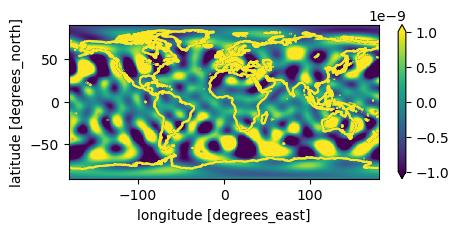

In [11]:
# roughly f0 per day would indicate MKS units? That is 1e-9. confirmed. 
V.truncate(avoradv, 20).sel(lev=200).plot(size=2, aspect=2.5, vmin = -1e-4/1e5, vmax = 1e-4/1e5) 
coastline()

Text(0.5, 1.0, 'dPhi/dp (MKS unit)')

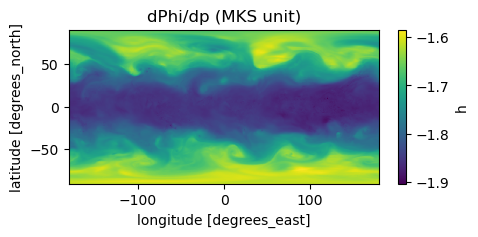

In [17]:
## GPTHICKNESS ADVECTION dPhi/dp and its horizontal advection at say 850

Phi = ds.h.fillna(0) * 9.8    # J/kg PE units 
dphidp = Phi.differentiate('lev')/100. ## GPM/Pa 
dphidp.sel(lev=400).plot(size=2, aspect=2.5); plt.title('dPhi/dp (MKS unit)')
# negative, about -1.5 in troposphere, yes -16000m*9.8/100000 Pa

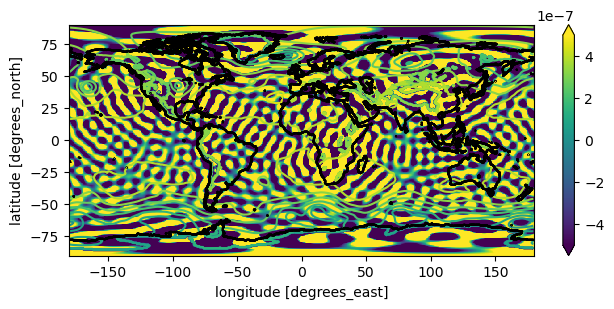

In [21]:
# Notice that thk is NEGATIVE, so its advection rate is negative for WARM WAA
# (GP/Pa) per second units, should be about (0.1)/1e6 (Eq-Pole)/(10 days)

dthkdx,dthkdy = V.gradient(dphidp) ## MKS units on gradient
thk_adv = -u*dthkdx - v*dthkdy     ## J/kg /Pa /s 

# Thickness advection plot to check units are right 
#V.truncate(thk_adv, truncation=42).sel(lev=850).plot(size=3, aspect=2.5, vmin=-5e-7, vmax=5e-7)
#Phi.sel(lev=850).plot.contour(levs=20)
#coastline(colors='k'); # Confirm 

-------------------
## At last, build the terms we want. MKS units 

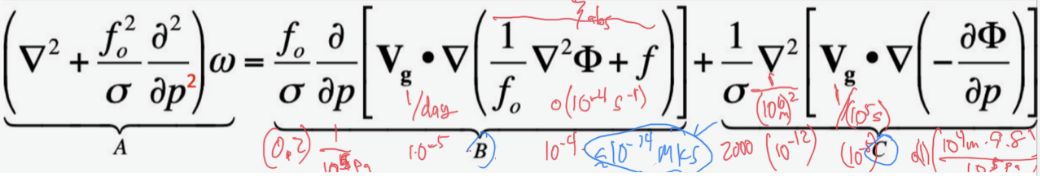

In [23]:
# Use total winds and total vorticity; notice advection is MINUS V.del(stuff) 
# units of inverse seconds per Pa ### 10^-13 values
TRUNC = 85

TERMB = -f0/sigma * V.truncate(avoradv, TRUNC).differentiate('lev') /100.  

In [24]:
# Laplacian (divergence of gradient) of thickness advection: MKS units throughout
# Gradient method is attached to V but does not use V 

gradx, grady = V.gradient(thk_adv)  # (GP/S per meter)
gradTA = windspharm.xarray.VectorWind(gradx, grady)
LapTA = gradTA.divergence(truncation=TRUNC)  # divergence of gradient, all in MKS (meters) derivatives 

TERMC = LapTA/sigma  ### advection is -V.grad

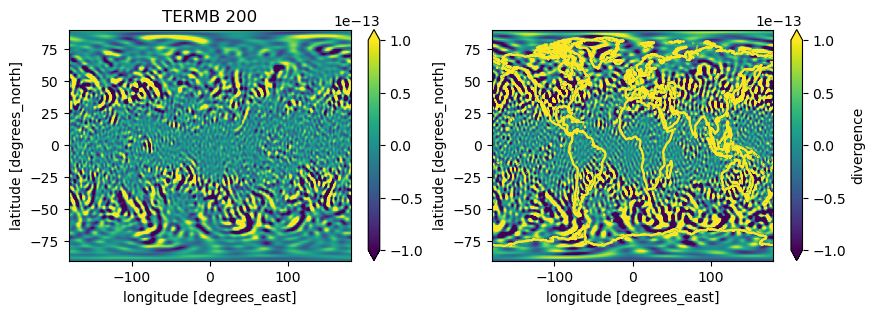

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# fig, axs = plt.subplots(ncols=2)

#TERMB.sel(lev=200).plot(ax=axs[0]); axs[0].set_title('TERMB 200')
#TERMC.sel(lev=200).plot(ax=axs[1]); axs[1].set_title('TERMC 200');

TERMB.sel(lev=200).plot(ax=axs[0], vmin=-1e-13, vmax=1e-13); axs[0].set_title('TERMB 200')
TERMC.sel(lev=200).plot(ax=axs[1], vmin=-1e-13, vmax=1e-13); axs[1].set_title('TERMC 200');
coastline()

## Grab a box in the NEpac for testing, and coarsen to 1 degree 
#### already truncated to TRUNC above 

In [67]:
FB = TERMB.sel(lat=slice(55,15-0.5), lon=slice(-125,-64.2), lev=slice(1000,100))
FC = TERMC.sel(lat=slice(55,15-0.5), lon=slice(-125,-64.2), lev=slice(1000,100))

In [68]:
FB

<xarray.DataArray (lev: 25, lat: 82, lon: 98)>
array([[[-2.63752846e-14, -3.40431452e-14, -4.15342064e-14, ...,
          6.72626153e-14,  5.88537677e-15, -7.11390853e-14],
        [ 9.86958555e-15, -1.30873934e-14, -3.71848413e-14, ...,
          7.25617889e-14,  1.11694118e-14, -6.67010053e-14],
        [ 5.29175431e-14,  2.14654581e-14, -1.44046542e-14, ...,
          7.61692955e-14,  2.26392323e-14, -4.70060053e-14],
        ...,
        [ 1.51274765e-14,  2.26756158e-14,  2.18884444e-14, ...,
         -2.02623427e-14, -3.94035289e-14, -3.91562291e-14],
        [ 1.49864032e-14,  2.30102446e-14,  2.37169937e-14, ...,
         -6.01708286e-14, -5.59113133e-14, -3.45249918e-14],
        [ 7.78258954e-15,  1.48955470e-14,  1.74141944e-14, ...,
         -7.42482790e-14, -5.52657387e-14, -2.47496014e-14]],

       [[ 3.60032117e-15, -1.55341629e-15, -6.24239015e-15, ...,
         -8.44574434e-15, -3.94098808e-15, -5.03051597e-15],
        [ 1.18836393e-14,  4.95167668e-15, -1.21282095e-15, ...,
          9.80817672e-16, -1.61052071e-15, -1.05011113e-14],
        [ 1.64868881e-14,  9.09795971e-15,  2.07337106e-15, ...,
          1.62864276e-14,  7.56431339e-15, -7.96297622e-15],
...
         -5.95793912e-15, -1.10277583e-14, -1.65509137e-14],
        [ 1.15488131e-13,  8.68304791e-14,  3.83121743e-14, ...,
         -1.91048586e-14, -2.29732547e-14, -2.40469249e-14],
        [ 1.18513015e-13,  8.70767014e-14,  3.89214316e-14, ...,
         -2.53710525e-14, -2.74765579e-14, -2.44335598e-14]],

       [[-1.42808535e-14, -1.59853210e-14, -1.81059798e-14, ...,
         -4.16267532e-14, -3.68134918e-14, -3.15901683e-14],
        [-1.45561968e-14, -1.88517669e-14, -2.32626266e-14, ...,
         -3.86150428e-14, -3.73356030e-14, -3.59712938e-14],
        [-7.26416133e-15, -1.48206303e-14, -2.22711321e-14, ...,
         -2.84468595e-14, -3.04880937e-14, -3.31269029e-14],
        ...,
        [ 2.28032738e-14,  2.27668565e-14,  1.69349940e-14, ...,
          2.70213992e-15, -3.87792012e-15, -1.16668336e-14],
        [ 1.52863646e-14,  1.92633046e-14,  1.61200094e-14, ...,
          1.29869929e-15, -2.27882335e-15, -8.05258299e-15],
        [ 4.15602730e-15,  1.17947127e-14,  1.19916826e-14, ...,
         -5.55583998e-16,  7.18454881e-16, -1.09329952e-15]]],
      dtype=float32)
Coordinates:
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * lat      (lat) float64 55.0 54.5 54.0 53.5 53.0 ... 16.5 16.0 15.5 15.0 14.5
  * lon      (lon) float64 -125.0 -124.4 -123.8 -123.1 ... -65.62 -65.0 -64.38
    time     datetime64[ns] 1998-11-10T09:00:00

In [71]:
Fds = FB.to_dataset(name='DVA')
Fds['LapTA'] = FC
Fds['Phi'] = Phi.       sel(lat=slice(55,15-0.5), lon=slice(-125,-64.2), lev=slice(1000,100))
Fds['omega'] = ds.omega.sel(lat=slice(55,15-0.5), lon=slice(-125,-64.2), lev=slice(1000,100))
Fds['dPhidp'] = dphidp.sel(lat=slice(55,15-0.5), lon=slice(-125,-64.2), lev=slice(1000,100))

Fds = Fds.coarsen(lat=2, lon=2).mean()
Fds.to_netcdf('./QGOE_forcing_WHch8case_M2coarsened_trunc'+str(TRUNC)+'.nc')
Fds

<xarray.Dataset>
Dimensions:  (lev: 25, lat: 41, lon: 49)
Coordinates:
  * lev      (lev) float64 1e+03 975.0 950.0 925.0 ... 250.0 200.0 150.0 100.0
  * lat      (lat) float64 54.75 53.75 52.75 51.75 ... 17.75 16.75 15.75 14.75
  * lon      (lon) float64 -124.7 -123.4 -122.2 -120.9 ... -67.19 -65.94 -64.69
    time     datetime64[ns] 1998-11-10T09:00:00
Data variables:
    DVA      (lev, lat, lon) float32 -1.591e-14 -4.606e-14 ... -2.677e-15
    LapTA    (lev, lat, lon) float32 -2.679e-13 -1.938e-13 ... -1.201e-14
    Phi      (lev, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    omega    (lev, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    dPhidp   (lev, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
ds